In [ ]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets

In [1]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

# Download latest version
path = kagglehub.dataset_download("valakhorasani/electric-vehicle-charging-patterns")
file_path = os.path.join(path, "ev_charging_patterns.csv")

df = pd.read_csv(file_path)

print(f"Numero di righe nel dataset: {df.shape[0]}")

print(df.head())
print(df.tail())

Numero di righe nel dataset: 1320
  User ID Vehicle Model  Battery Capacity (kWh) Charging Station ID  \
0  User_1        BMW i3              108.463007         Station_391   
1  User_2  Hyundai Kona              100.000000         Station_428   
2  User_3    Chevy Bolt               75.000000         Station_181   
3  User_4  Hyundai Kona               50.000000         Station_327   
4  User_5  Hyundai Kona               50.000000         Station_108   

  Charging Station Location  Charging Start Time    Charging End Time  \
0                   Houston  2024-01-01 00:00:00  2024-01-01 00:39:00   
1             San Francisco  2024-01-01 01:00:00  2024-01-01 03:01:00   
2             San Francisco  2024-01-01 02:00:00  2024-01-01 04:48:00   
3                   Houston  2024-01-01 03:00:00  2024-01-01 06:42:00   
4               Los Angeles  2024-01-01 04:00:00  2024-01-01 05:46:00   

   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  \
0              60.712346 

In [2]:
# Rimuovere i valori nulli (elimina intero record = riga)
df_cleaned = df.dropna()

print(f"Numero di righe nel dataset senza valori nulli: {df_cleaned.shape[0]}")

Numero di righe nel dataset senza valori nulli: 1131


In [3]:
# Rinominare le colonne
df_cleaned = df_cleaned.rename(columns={
    'User ID': 'user_id',
    'Vehicle Model': 'vehicle_model',
    'Battery Capacity (kWh)': 'battery_capacity_kwh',
    'Charging Station ID': 'station_id',
    'Charging Station Location': 'station_location',
    'Charging Start Time': 'start_time',
    'Charging End Time': 'end_time',
    'Energy Consumed (kWh)': 'energy_consumed_kwh',
    'Charging Duration (hours)': 'duration_hours',
    'Charging Rate (kW)': 'rate_kw',
    'Charging Cost (USD)': 'cost_usd',
    'Time of Day': 'time_of_day',
    'Day of Week': 'day_of_week',
    'State of Charge (Start %)': 'soc_start_percent',
    'State of Charge (End %)': 'soc_end_percent',
    'Distance Driven (since last charge) (km)': 'distance_km',
    'Temperature (°C)': 'temperature_c',
    'Vehicle Age (years)': 'vehicle_age_years',
    'Charger Type': 'charger_type',
    'User Type': 'user_type'
})

print(f"Numero di righe nel dataset senza valori nulli: {df_cleaned.shape[0]}")

# Visualizzare il dataset trasformato
print("\nDataset trasformato:")
print(df_cleaned.head())

# Salvare il dataset pulito in un nuovo file
""" output_file = 'cleaned_ev_charging_patterns.csv'
df_cleaned.to_csv(output_file, index=False)
print(f"\nDataset pulito e salvato in: {output_file}") """

Numero di righe nel dataset senza valori nulli: 1131

Dataset trasformato:
  user_id vehicle_model  battery_capacity_kwh   station_id station_location  \
0  User_1        BMW i3            108.463007  Station_391          Houston   
1  User_2  Hyundai Kona            100.000000  Station_428    San Francisco   
2  User_3    Chevy Bolt             75.000000  Station_181    San Francisco   
3  User_4  Hyundai Kona             50.000000  Station_327          Houston   
4  User_5  Hyundai Kona             50.000000  Station_108      Los Angeles   

            start_time             end_time  energy_consumed_kwh  \
0  2024-01-01 00:00:00  2024-01-01 00:39:00            60.712346   
1  2024-01-01 01:00:00  2024-01-01 03:01:00            12.339275   
2  2024-01-01 02:00:00  2024-01-01 04:48:00            19.128876   
3  2024-01-01 03:00:00  2024-01-01 06:42:00            79.457824   
4  2024-01-01 04:00:00  2024-01-01 05:46:00            19.629104   

   duration_hours    rate_kw   cost_usd t

' output_file = \'cleaned_ev_charging_patterns.csv\'\ndf_cleaned.to_csv(output_file, index=False)\nprint(f"\nDataset pulito e salvato in: {output_file}") '

# Classificazione
Creazione di un **modello predittivo** per classificare gli utenti in base al loro comportamento di ricarica

In [4]:
# Feature Engineering
df_cleaned['start_hour'] = pd.to_datetime(df_cleaned['start_time']).dt.hour
df_cleaned['day_of_week'] = df_cleaned['day_of_week'].astype('category').cat.codes

# Seleziona le variabili rilevanti
features = ['start_hour', 'duration_hours', 'day_of_week', 'energy_consumed_kwh']
X = df_cleaned[features]

# Crea etichette basate su regole di classificazione
def classify_user(row):
    if row['duration_hours'] > 3 and row['energy_consumed_kwh'] > 50:
        return 'utenti intensivi'
    elif row['duration_hours'] > 1:
        return 'utenti frequenti'
    else:
        return 'utenti occasionali'

df_cleaned['user_type'] = df_cleaned.apply(classify_user, axis=1)

# Codifica la variabile target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cleaned['user_type'])

In [6]:
# Impostazioni del bootstrap
n_iterations = 10000000  # Numero di campioni bootstrap
checkpoint_interval = 100000  # Numero di iterazioni tra i checkpoint
checkpoint_file = "bootstrap_checkpoint.pkl"  # Nome file per il checkpoint

# Controlla se esiste un checkpoint
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, "rb") as f:
        checkpoint = pickle.load(f)
        start_iteration = checkpoint['iteration'] + 1
        metrics = checkpoint['metrics']
else:
    start_iteration = 0
    metrics = []

for i in range(n_iterations):
    # Campionamento con sostituzione
    bootstrap_indices = np.random.choice(range(len(X)), size=len(X), replace=True)
    oob_indices = list(set(range(len(X))) - set(bootstrap_indices))
    
    # Crea training e test set
    X_train = X.iloc[bootstrap_indices]
    y_train = y[bootstrap_indices]
    X_test = X.iloc[oob_indices]
    y_test = y[oob_indices]

KeyboardInterrupt: 

Accuracy: 100.00%
                    precision    recall  f1-score   support

  utenti frequenti       1.00      1.00      1.00       299
  utenti intensivi       1.00      1.00      1.00        50
utenti occasionali       1.00      1.00      1.00        62

          accuracy                           1.00       411
         macro avg       1.00      1.00      1.00       411
      weighted avg       1.00      1.00      1.00       411



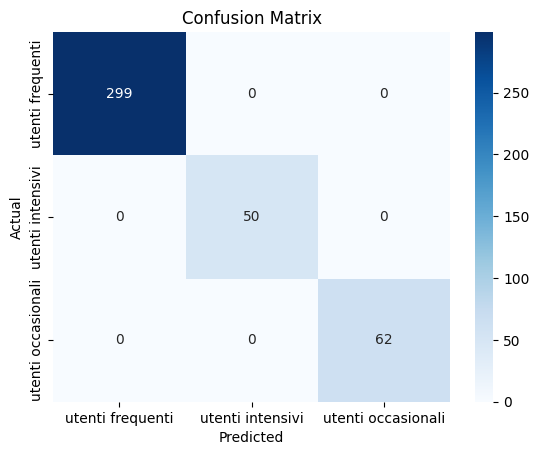

Bootstrap Accuracy: Mean = nan, Std Dev = nan


In [7]:
# Addestra un Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
    )
model.fit(X_train, y_train)

# Valuta il modello
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Salva il checkpoint ogni `checkpoint_interval` iterazioni
if (i + 1) % checkpoint_interval == 0 or (i + 1) == n_iterations:
    checkpoint = {
        "iteration": i,
        "metrics": metrics
    }
    with open(checkpoint_file, "wb") as f:
        pickle.dump(checkpoint, f)
    print(f"Checkpoint salvato all'iterazione {i + 1}")

# Matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Report finale
print(f"Bootstrap Accuracy: Mean = {np.mean(metrics):.2f}, Std Dev = {np.std(metrics):.2f}")

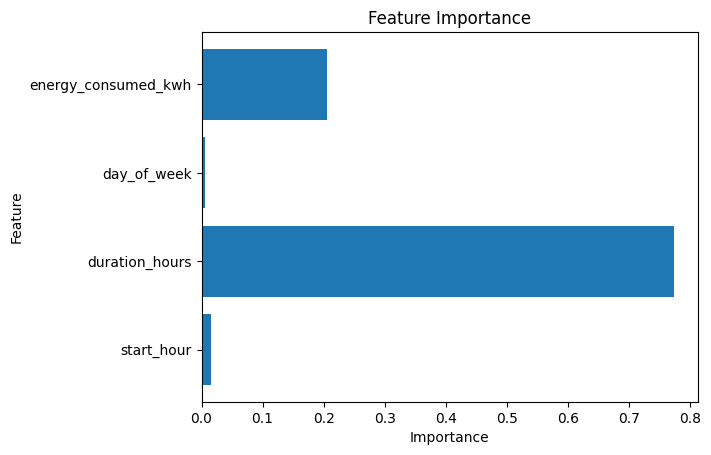

In [18]:
# Importanza delle feature
importances = model.feature_importances_
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Regressione
- Obiettivo 1: stimare la durata della sessione di ricarica in funzione di caratteristiche come il giorno della settimana, l’orario di inizio e l’energia consumata.
- Obiettivo 2: Prevedere il consumo energetico totale basandosi sulle stesse variabili.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepara il dataset per la regressione
features = ['day_of_week', 'start_hour', 'energy_consumed_kwh']
X = df_cleaned[features]